In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from collections import defaultdict
import re
import os

In [16]:
def get_lines(filename, regex):
    lines = []
    with open(filename, 'r') as f:
        for line in f.readlines():
            match = re.findall(regex, line)
            if match:
                line = line.strip()
                lines.append(line)
    return lines

In [31]:
def get_train_vals(lines, start, step):
    # Example: [2020-02-12 14:25:03,474 INFO] Step 74100/100000; acc:  90.83; ppl:  1.25; xent: 0.22; lr: 0.00007; 122527/26997 tok/s;    111 sec
    vals = defaultdict(list)
    for i in range(start, len(lines), step):
        fields = lines[i].split(';')[1:4]
        kv_raw = [field.strip().split(':') for field in fields]
        kv = [[k.strip(), float(v.strip())] for k, v in kv_raw]
        for k, v in kv:
            vals[k].append(v)
    return vals

In [32]:
def get_valid_vals(lines, start, step):
    vals = []
    for i in range(start, len(lines), step):
        colon_pos = lines[i].rfind(':')
        val = float(lines[i][colon_pos+1:].strip())
        vals.append(val)
    return np.array(vals)

In [33]:
# filename = '../slurm/slurm-809323.out'
filename_template = '../slurm/slurm-{0}.out'
jobids = [792747, 794676, 803054, 809323]

In [44]:
train_xents = []
train_ppls = []
train_accs = []
for jobid in jobids:
    filename = filename_template.format(jobid)
    train_lines = get_lines(filename, r'Step [0-9]*/[0-9]*')
    part_vals = get_train_vals(train_lines, 0, 1)
    train_xents.append(part_vals['xent'])
    train_ppls.append(part_vals['ppl'])
    train_accs.append(part_vals['acc'])
train_xents = np.concatenate(train_xents)
train_ppls = np.concatenate(train_ppls)
train_accs = np.concatenate(train_accs)
print(len(train_xents), len(train_ppls), len(train_accs))
train_xents[:3], train_ppls[:3], train_accs[:3]

1010 1010 1010


(array([1.9 , 1.5 , 1.38]),
 array([6.68, 4.46, 3.98]),
 array([34.09, 44.08, 47.3 ]))

In [45]:
train_accs[30:40]

array([68.6 , 68.06, 69.82, 69.39, 70.69, 70.36, 70.81, 71.44, 72.37,
       71.59])

In [46]:
# Correction for restart
i = 30
j = 40
train_xents = np.concatenate([train_xents[:i], train_xents[j:]])
train_ppls = np.concatenate([train_ppls[:i], train_ppls[j:]])
train_accs = np.concatenate([train_accs[:i], train_accs[j:]])
print(len(train_xents), len(train_ppls), len(train_accs))
train_xents[:3], train_ppls[:3], train_accs[:3]

1000 1000 1000


(array([1.9 , 1.5 , 1.38]),
 array([6.68, 4.46, 3.98]),
 array([34.09, 44.08, 47.3 ]))

In [47]:
ppls = []
accs = []
for jobid in jobids:
    filename = filename_template.format(jobid)
    validation_lines = get_lines(filename, r'Validation')
    part_ppls = get_valid_vals(validation_lines, 0, 2)
    part_accs = get_valid_vals(validation_lines, 1, 2)
    ppls.append(part_ppls)
    accs.append(part_accs)
ppls = np.concatenate(ppls)
accs = np.concatenate(accs)
len(ppls), len(accs)

(100, 100)

In [48]:
train_xs = np.arange(len(train_ppls))
xs = np.arange(len(ppls))

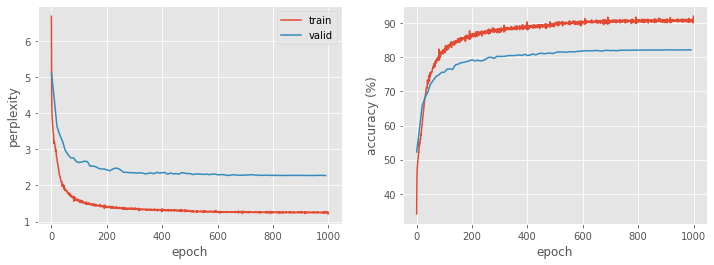

In [68]:
plt.style.use('ggplot')

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for axis in ax:
    axis.set_xlabel('epoch')
#     axis.set_xscale('symlog')
#     axis.set_xticks([0, 3, 10, 30, 100])
#     axis.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

start = None
end = None

ax[0].plot(train_xs[start:end], train_ppls[start:end], label='train')
ax[0].plot(10*xs[start:end], ppls[start:end], label='valid')
ax[0].set_ylabel('perplexity')
ax[0].legend(loc=0)

ax[1].plot(train_xs[start:end], train_accs[start:end], label='train')
ax[1].plot(10*xs[start:end], accs[start:end], label='valid')
ax[1].set_ylabel('accuracy (%)')
ax[0].legend(loc=0)


In [55]:
train_ppls_avg = train_ppls.reshape(-1, 100).mean(axis=0)
train_accs_avg = train_accs.reshape(-1, 100).mean(axis=0)
train_ppls_avg.shape

(100,)

Text(0, 0.5, 'accuracy (%)')

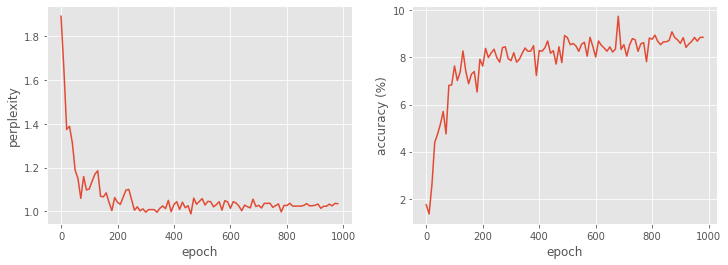

In [64]:
plt.style.use('ggplot')

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for axis in ax:
    axis.set_xlabel('epoch')
#     axis.set_xscale('symlog')
#     axis.set_xticks([0, 3, 10, 30, 100])
#     axis.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

start = None
end = -1

ax[0].plot(10*xs[start:end], -(train_ppls[10::10] - ppls[start:end]))
# ax[0].plot(10*xs[start:end], -(train_ppls_avg[start:end] - ppls[start:end]))
ax[0].set_ylabel('perplexity')

ax[1].plot(10*xs[start:end], train_accs[10::10] - accs[start:end])
# ax[1].plot(10*xs[start:end], train_accs_avg[start:end] - accs[start:end])
ax[1].set_ylabel('accuracy (%)')

In [90]:
np.argmin(ppls), np.argmax(accs)

(64, 99)

In [91]:
ppls[64], ppls[99]

(2.27279, 2.27289)

In [92]:
accs[64], accs[99]

(81.9462, 82.1938)

In [3]:
line = '[2020-02-12 14:25:03,474 INFO] Step 74100/100000; acc:  90.83; ppl:  1.25; xent: 0.22; lr: 0.00007; 122527/26997 tok/s;    111 sec'

In [11]:
fields = line.split(';')[1:4]
kv_raw = [field.strip().split(':') for field in fields]
kv = [[k.strip(), float(v.strip())] for k, v in kv_raw]
kv

[['acc', 90.83], ['ppl', 1.25], ['xent', 0.22]]